# Light Gradient Boosting

This notebook will use the tree based model call Light Gradient Boosting. Like Extreme Boosting, Light Gradient Boosting Machine follows the principle of GBM but it is more efficient and cost less resources. Please see more details in `LightGBM_Engine.py` for how I use LightGBM.

In [1]:
import utils
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
import LightGBM_Engine as LgbEn
from hyperopt import hp

## Read saved data sets

Read saved pickle format data sets from `1_Data_Exploration.ipynb`

* training data set (`X_train`, `y_train`), 60% of full `train_features.csv`: used with validation data set for hyperparameter tuning 
* validation data set (`X_val`, `y_val`), 20% of full `train_features.csv`: used with training data set for hyperparameter tuning 
* testing data set (`X_test`, `y_test`), 20% of full `train_features.csv`: used for comparing to other models

In [2]:
X_train = pd.read_pickle("X_train.pkl")
X_val = pd.read_pickle("X_val.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_val = pd.read_pickle("y_val.pkl")
y_test = pd.read_pickle("y_test.pkl")

In [3]:
gc.collect()

14

## Get default hyperparameters

Start with the taining with the default hyperparameters.

In [4]:
LGB_default = lgb.LGBMRegressor()
LGB_default.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [5]:
vars_drop = ['major_new']
X_train_1, X_val_1, X_test_1 = utils.drop_vars(vars_drop, X_train, X_val, X_test)  
categorical_vars = utils.get_categorical_variables(X_train_1)

Create two functions below for training and hyperparameter tuning

* `run_lgb`: manual tuning to find hyperparameter space

In [6]:
def run_lgb(encoding, hyperparameters, test_data, param=None, value=None):
    if param and value:
        hyperparameters[param] = value
    LGB = LgbEn.LightGBM_Engine(X_train_1, y_train, X_val_1, y_val, encoding, None, 'rmse')


    var_cate, features_DEV, features_OOT, labels_DEV, labels_OOT, weights_DEV, weights_OOT = LGB.get_datasets()

    DEV_set, OOT_set, feature_names = LGB.encoding(var_cate, features_DEV, \
                                                   features_OOT, labels_DEV, labels_OOT, weights_DEV, weights_OOT)
    model, evals_results, hyperparameters, DEV_metric, OOT_metric, run_time = \
                                                LGB.train(DEV_set, OOT_set, hyperparameters) 
    
    gbm_pred = model.predict(test_data)
    
    
    print("Train RMSE is {}".format(DEV_metric))
    print("Valid RMSE is {}".format(OOT_metric))
    model_name = "Test data is"
    utils.check_RMSE(model_name, y_test, gbm_pred)
    print("________________")
    print(hyperparameters)

* `tune_lgb`: apply Bayesian optimization to find best hyperparameter in hyperparameter space

In [7]:
def tune_lgb(encoding, space, X_test, records, model_dir):
    LGB_1 = LgbEn.LightGBM_Engine(X_train_1, y_train, X_val_1, y_val, encoding, None, 'rmse')
    table, features, importance, selected, hyperparameters, best_results = \
                LGB_1.evaluation(space, records, model_dir)
    
    best_model = lgb.Booster(model_file=model_dir)
    best_model.params['objective'] = 'regression'
    gbm_pred = best_model.predict(X_test)
    
    print("Train RMSE is {}".format(table[1]))
    print("Valid RMSE is {}".format(table[2]))
    model_name = "Test data is"
    utils.check_RMSE(model_name, y_test, gbm_pred)
    print("________________")
    print(hyperparameters)
    
    return best_model, pd.concat([features, importance], axis = 1)

## 1. One hot encoding

In [8]:
_, X_test_hot_encode = utils.encoding('one hot', categorical_vars, X_train_1, X_test_1)

In [9]:
X_test_hot_encode.shape

(199939, 31)

Start with default hyperparameter in LighGBM, used manual tuning to find a good hyperparameter space. Change one hyperparameter with more or less than default choice when other hyperparameters are fixed. The code below are examples, more runs are tested to get final feature space for Bayesian optimization.

In [10]:
hyperparameters = LGB_default.get_params()
print(hyperparameters)
run_lgb(True, hyperparameters, X_test_hot_encode)
run_lgb(True, hyperparameters, X_test_hot_encode, 'learning_rate', 0.01)
run_lgb(True, hyperparameters, X_test_hot_encode, 'learning_rate', 0.05)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
Train RMSE is 18.684162696240595
Valid RMSE is 18.90072735026722
RMSE of model Test data is is:  18.88978325543786
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 379, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
Train RMSE is 18.73420323603321
Valid RMSE is 18.867287285496584
RMSE of model Test data is is:  18.862428486015208
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
Train RMSE is 18.72498884089342
Valid RMSE is 18.877077945965137
RMSE of model Test data is is:  18.872517367041073
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 479, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Found the hyperparameters space below to tune. The maximum trees we build will not exceed 2000 trees and it will early stop if validation data performance has not changed for 50 runs

In [11]:
space = {
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
            'num_leaves': hp.choice('num_leaves', range(15, 127, 1)),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'subsample_for_bin': hp.choice('subsample_for_bin', range(20000, 300000, 20000)),
            'min_child_samples': hp.choice('min_child_samples', range(20, 500, 5)),
            'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda':  hp.uniform('reg_lambda', 0.0, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
        } 

    
best, importance_table = tune_lgb(True, space, X_test_hot_encode, 'GBM_records_onehot.csv', 'GBM_onehot.txt')

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



100%|██████████| 50/50 [58:15<00:00, 69.92s/it, best loss: 18.848213638327298] 
Train RMSE is 18.722198047015407
Valid RMSE is 18.848213638327298
RMSE of model Test data is is:  18.84082041561113
________________
{'colsample_bytree': 0.6493995962757044, 'learning_rate': 0.010704995006600644, 'min_child_samples': 405, 'num_leaves': 57, 'reg_alpha': 0.011916940209808716, 'reg_lambda': 0.02290033834427313, 'subsample': 0.5117220236533342, 'subsample_for_bin': 280000, 'n_estimators': 1416}


Plot the feature importance

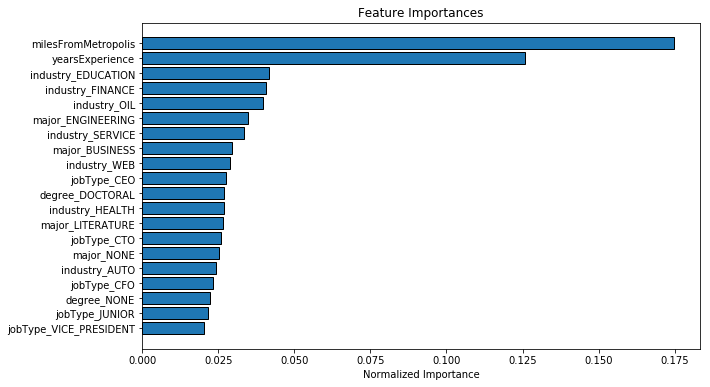

In [12]:
utils.plot_importance(importance_table, 20)

## 2. Label encoding

LightGBM has a very good feature that can handle categorical variables without one hot encoding. It uses the Optimal Split for Categorical Features that split on a categorical feature by partitioning its categories into 2 subsets. If the feature has k categories, there are $2^{(k-1)} - 1$ possible partitions. Thus, we used label encoding here and specified categorical variables in lightgbm data set. 

In [13]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_vars:
    le.fit(X_test_1[col])
    X_test_1[col] = le.transform(X_test_1[col])

Start with default hyperparameter in LighGBM, used manual tuning to find a good hyperparameter space. Change one hyperparameter with more or less than default choice when other hyperparameters are fixed. The code below are examples, more runs are tested to get final feature space for Bayesian optimization.

In [14]:
hyperparameters = LGB_default.get_params()
print(hyperparameters)
run_lgb(False, hyperparameters, X_test_1)
run_lgb(False, hyperparameters, X_test_1, 'learning_rate', 0.01)
run_lgb(False, hyperparameters, X_test_1, 'learning_rate', 0.05)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Train RMSE is 18.727764018269355
Valid RMSE is 18.880264863099864
RMSE of model Test data is is:  18.88048238788432
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 209, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Train RMSE is 18.74324634488969
Valid RMSE is 18.861898647527184
RMSE of model Test data is is:  18.85908380872394
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Train RMSE is 18.73604972582947
Valid RMSE is 18.865397442448877
RMSE of model Test data is is:  18.865233484334397
________________
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 461, 'num_leaves': 31, 'objective': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Found the hyperparameters space below to tune. The maximum trees we build will not exceed 2000 trees and it will early stop if validation data performance has not changed for 50 runs

In [15]:
space = {
            'num_leaves': hp.choice('num_leaves', range(20, 150, 1)),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
            'subsample_for_bin': hp.choice('subsample_for_bin', range(20000, 300000, 20000)),
            'min_child_samples': hp.choice('min_child_samples', range(20, 500, 5)),
            'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda':  hp.uniform('reg_lambda', 0.0, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
        } 
best, importance_table = tune_lgb(False, space, X_test_1, 'GBM_records_label.csv', 'GBM_label.txt')

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



100%|██████████| 50/50 [37:05<00:00, 44.52s/it, best loss: 18.84976411895737] 
Train RMSE is 18.726145713367533
Valid RMSE is 18.84976411895737
RMSE of model Test data is is:  18.843244159999223
________________
{'colsample_bytree': 0.6745171777617696, 'learning_rate': 0.017834840095378862, 'min_child_samples': 385, 'num_leaves': 37, 'reg_alpha': 0.2892601062868556, 'reg_lambda': 0.09999714603767595, 'subsample_for_bin': 60000, 'n_estimators': 1437}


Plot the feature importance

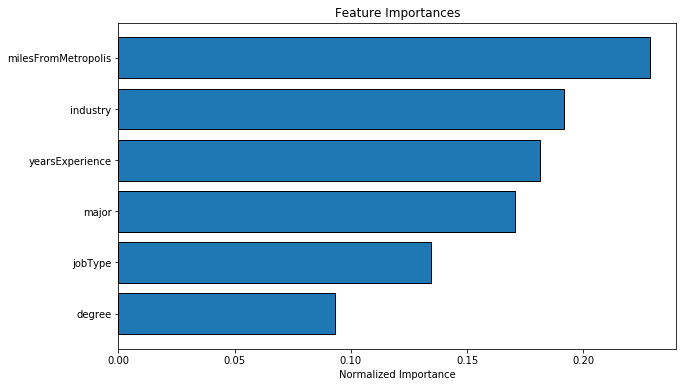

In [16]:
utils.plot_importance(importance_table, 6)

## Summary

Both one hot encoding label encoding have very similar results that RMSE of test data is close to 18.84. Both of them have better performance than linear models. Label encoding version is selected because it has less variables and faster to train and implement.